In [1]:
#Connecting to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import AUTOTUNE

# Set path to your dataset
data_dir = '/content/drive/MyDrive/chest_xray (1)'

#Resizing image and configuring batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load training data
train_ds = image_dataset_from_directory(
    directory=f"{data_dir}/train",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

#Load validation data
val_ds = image_dataset_from_directory(
    directory=f"{data_dir}/val",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load test data
test_ds = image_dataset_from_directory(
    directory=f"{data_dir}/test",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Prefetch batch for optimized performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 6818 files belonging to 2 classes.
Found 1172 files belonging to 2 classes.
Found 586 files belonging to 2 classes.


In [3]:
# Optimize
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [4]:
from tensorflow.keras import layers
#data augmentation
data_augmentation = tf.keras.Sequential([

    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2)
])


In [5]:
def build_simple_cnn():
    model = tf.keras.Sequential([
        data_augmentation,
        tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [6]:
simple_cnn = build_simple_cnn()
simple_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

simple_cnn_history = simple_cnn.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


214/214 ━━━━━━━━━━━━━━━━━━━━ 1692s 8s/step - accuracy: 0.8134 - loss: 0.7388 - val_accuracy: 0.8993 - val_loss: 0.2630
Epoch 2/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 86s 404ms/step - accuracy: 0.9595 - loss: 0.1181 - val_accuracy: 0.9462 - val_loss: 0.1764
Epoch 3/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 141s 400ms/step - accuracy: 0.9733 - loss: 0.0772 - val_accuracy: 0.9394 - val_loss: 0.2181
Epoch 4/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 133s 358ms/step - accuracy: 0.9878 - loss: 0.0389 - val_accuracy: 0.8882 - val_loss: 0.5098
Epoch 5/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 92s 407ms/step - accuracy: 0.9940 - loss: 0.0208 - val_accuracy: 0.9317 - val_loss: 0.3063


In [7]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Get predicted probabilities
y_probs = simple_cnn.predict(test_ds)
y_pred = (y_probs > 0.5).astype("int").flatten()


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step


In [8]:
# Accuracy
print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))


Accuracy: 92.49%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.94      0.91      0.92       293
   PNEUMONIA       0.91      0.94      0.93       293

    accuracy                           0.92       586
   macro avg       0.93      0.92      0.92       586
weighted avg       0.93      0.92      0.92       586



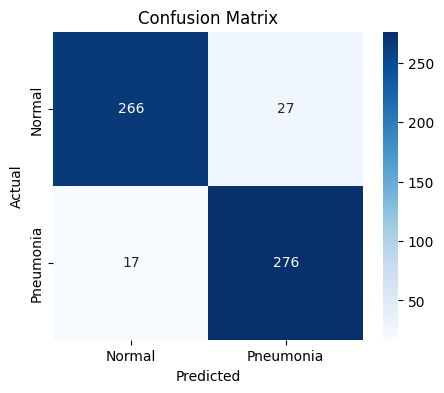

In [9]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [10]:
auc = roc_auc_score(y_true, y_probs)
print(f"AUC Score: {auc:.4f}")


AUC Score: 0.9789


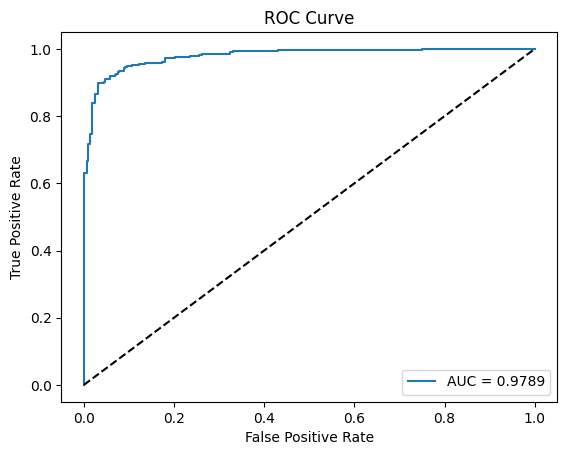

In [11]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
